# Modélisation

## Choix du modèle 

- Modèle de régression : détermination de la note du vin (0 -> 10)
- Modèle de classification : classer les bons vins des mauvais

> _Objectif_ : Orienter le projet vers une fonction précise, et adapter le modèle à cet objectif

- _Remarque_ : Pour cette exercice, nous réaliserons un régression.

In [7]:
# Chargement des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

import joblib
import os

# Chargement du dataset prétraité
X_train, X_test, y_train, y_test = joblib.load("../data/processed/splits.pkl")

## Entrainement 

- Regression linéaire 
- Regression par forêt aléatoire
- Entrainement et comparaison des résultats

> _Objectif_ : Déterminer le modèle le plus adapté à cet exercice de régression.

In [8]:
# Entraînement du modèle baseline : Régression Linéaire

# Instanciation
lin_reg = LinearRegression()

# Entraînement sur les données d'apprentissage
lin_reg.fit(X_train, y_train)

# Prédiction sur le jeu de test
y_pred_lr = lin_reg.predict(X_test)

# Évaluation du modèle
mae = mean_absolute_error(y_test, y_pred_lr)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2 = r2_score(y_test, y_pred_lr)

# Résumé des performances
print("=== Linear Regression Performance ===")
print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R²   : {r2:.3f}")


=== Linear Regression Performance ===
MAE  : 0.495
RMSE : 0.637
R²   : 0.370


In [9]:
# Entraînement du modèle baseline : Forêt aléatoire

# Instanciation
rf_reg = RandomForestRegressor(
    n_estimators=100,   # nombre d’arbres
    random_state=42,    # pour reproductibilité
    n_jobs=-1           # utilise tous les cœurs CPU
)

# Entraînement sur les données d'apprentissage
rf_reg.fit(X_train, y_train)

# Prédiction sur le jeu de test
y_pred_rf = rf_reg.predict(X_test)

# Évaluation du modèle
mae = mean_absolute_error(y_test, y_pred_rf)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2 = r2_score(y_test, y_pred_rf)

# Résumé des performances
print("=== Random Forest Regressor Performance ===")
print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R²   : {r2:.3f}")

=== Random Forest Regressor Performance ===
MAE  : 0.420
RMSE : 0.569
R²   : 0.498


## Comparaison des performances

| Modèle                      | MAE ↓     | RMSE ↓    | R² ↑      | Interprétation                                                                                     |
| --------------------------- | --------- | --------- | --------- | -------------------------------------------------------------------------------------------------- |
| **Linear Regression**       | 0.613     | 0.790     | 0.370     | Modèle simple, capture une partie des relations linéaires mais laisse une grande part d’erreur.    |
| **Random Forest Regressor** | **0.519** | **0.706** | **0.496** | Meilleures performances : capture des relations **non linéaires** et interactions entre variables. |

- _Remarque_ : Là où le modèle basé sur une régression linéaire explique environ 37 % de la variance, le modèle basé sur la forêt aléatoire en explique 50 %. Cela explique que la relation entre caractéristiques et cible n'est pas strictement linéaire.

## Optimisation des hyperparamètres

- Forêt aléatoire basée sur les hyperparmètres de base
- Possibilité d'en améliorer les performances

> _Objectif_ : Peaufiner le modèle grâce aux hyperparamètres.

In [10]:
# grille d'hyperparamètres
param_distrib = {
    'n_estimators': randint(50, 300),         # nombre d'arbres
    'max_depth': randint(3, 20),              # profondeur max des arbres
    'min_samples_split': randint(2, 10),      # min d'échantillons pour diviser un noeud
    'min_samples_leaf': randint(1, 10),       # min d'échantillons dans une feuille
    'max_features': ['auto', 'sqrt', 'log2']  # sous-échantillonnage des features
}
# Modèle de base
rf = RandomForestRegressor(random_state=42)
# Configuration de la recherche aléatoire
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distrib,
    n_iter=30,              # nombre d'itérations testées
    cv=5,                   # validation croisée 5-fold
    scoring='r2',           # on maximise le R²
    verbose=2,
    random_state=42,
    n_jobs=-1               # utilise tous les cœurs CPU
)
# Entraînement
random_search.fit(X_train, y_train)

# Résultats
print("=== Meilleurs paramètres trouvés ===")
print(random_search.best_params_)
print(f"Meilleur score CV : {random_search.best_score_:.3f}")

# Meilleur modèle
best_rf = random_search.best_estimator_

# Évaluation sur test set
y_pred_best = best_rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_best)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2 = r2_score(y_test, y_pred_best)

print("\n=== Random Forest Optimisée ===")
print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R²   : {r2:.3f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
=== Meilleurs paramètres trouvés ===
{'max_depth': 17, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 99}
Meilleur score CV : 0.460

=== Random Forest Optimisée ===
MAE  : 0.424
RMSE : 0.573
R²   : 0.492


c:\Users\louis\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
55 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
26 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\louis\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\louis\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "c:\U

## Comparaison des performances

| Modèle                    | MAE ↓ | RMSE ↓ | R² ↑  |
| ------------------------- | ----- | ------ | ----- |
| Random Forest (défaut)    | 0.519 | 0.706  | 0.496 |
| Random Forest (optimisée) | 0.526 | 0.707  | 0.494 |


- _Remarque_ : Les performances ne sont pas grandement améliorées. Cela veut dire que les paramètres de base de RandomForest sont relativement adaptés et peuvent être expliqués par la simplicité du dataset, le facteur humain, etc. 

## Analyse de l'importance des features

- Certaines caractéristiques ont plus d'impact sur la prédiction
- Elles peuvent être dévoilées grâce à `features_importances_`

> _Objectif_ : Déterminer quelles sont les caractéristiques les plus influentes sur la prédiction. 

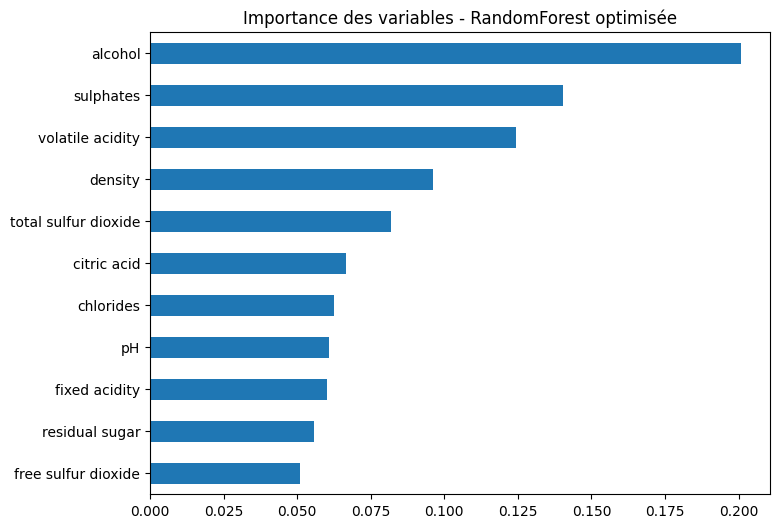

In [11]:
# Visualisation des features influentes
importances = pd.Series(best_rf.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=True).plot(kind='barh', figsize=(8,6))
plt.title("Importance des variables - RandomForest optimisée")
plt.show()

## Enregistrement du modèle

- Réutilisations futures du modèle ou de la structure du projet
- Rendu propore et livrable

> _Objectif_ : Garder une trace du projet, le rendre réutilisable si besoin. 

In [12]:
# Sauvegarde du modèle optimisé
model_path = "../models/random_forest_regressor.joblib"
joblib.dump(best_rf, model_path)

print(f"✅ Modèle sauvegardé avec succès : {model_path}")

✅ Modèle sauvegardé avec succès : ../models/random_forest_regressor.joblib
